# Full phase prediction

In this notebook we investigate the model perfomance when jointly predicting the full indicator vector of phase occurences. As usually we start with some global imports and fixation of a random seed for reproducibility of results.

In [1]:
import os
if not os.path.exists('common.py'):
    print('trying to find project root directory by chaning to parent directory')
    os.chdir('..')
if os.path.exists('common.py'):
    print('all good')
else:
    print('could not find project root directory')

trying to find project root directory by chaning to parent directory
all good


In [2]:
import pandas as pd
import numpy as np

seeds=1000

## Data and Models

Since we are concerned with modelling the full phase vector, our response matrix has three columns indicating presence of 'sphere', 'worm', and 'vesicle', respectively. We ignore other phases.

In [3]:
import data
x = data.x
y = data.y.filter(['sphere', 'worm', 'vesicle', 'other'], axis=1)
x.columns, y.columns

(Index(['clogp_corona', 'mon_corona_mw', 'mon_corona_apol', 'mon_corona_mv',
        'mon_corona_psa', 'dp_corona', 'corona_mw_total', 'corona_mv_total',
        'clogp_core', 'mon_core_mw', 'mon_core_apol', 'mon_core_mv',
        'mon_core_psa', 'dp_core', 'core_mw_total', 'core_mv_total',
        'ratio_mass', 'ratio_vol', 'conc', 'ph', 'salt', 'charged', 'temp',
        'core_BzMA', 'core_DAAM', 'core_EGEMA', 'core_GlyMA', 'core_HBMA',
        'core_HEMA', 'core_HPMA', 'core_MEMA', 'core_PhA', 'core_TFMA',
        'core_EGDMA', 'core_cyclic', 'corona_GMA', 'corona_MPC',
        'corona_AcETMAC', 'corona_MAA', 'corona_DMA', 'corona_PEG',
        'corona_CysMA', 'corona_GluMA', 'corona_DMAPS', 'corona_AEMA',
        'corona_QDMAEMA', 'corona_HPMAm', 'corona_KSPMA', 'corona_MAcEPyr',
        'corona_DSDMA'],
       dtype='object'),
 Index(['sphere', 'worm', 'vesicle', 'other'], dtype='object'))

For modelling, we focus on the best performing model for the indiviudal phases, the random forest model.

In [4]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import ClassifierChain
from modules.multilabel import BinaryRelevanceClassifier, ProbabilisticClassifierChain
from interpret.glassbox import ExplainableBoostingClassifier
from models import linear_base, gam_base, random_forest_base, rule_fit_base

lr_ind = BinaryRelevanceClassifier(linear_base)
lr_chain = ClassifierChain(linear_base, order=[0, 1, 2, 3])
lr_pcc = ProbabilisticClassifierChain(linear_base)

gam_ind = BinaryRelevanceClassifier(gam_base)
gam_chain = ClassifierChain(gam_base)
gam_pcc = ProbabilisticClassifierChain(gam_base)

rf_ind = BinaryRelevanceClassifier(random_forest_base)
rf_chain = ClassifierChain(random_forest_base, order=[0, 1, 2, 3]) #order=[0, 2, 1, 3])
rf_pcc = ProbabilisticClassifierChain(random_forest_base)

# rulefit_ind = BinaryRelevanceClassifier(rule_fit_base)
# rulefit_chain = ClassifierChain(rule_fit_base, order=[0, 1, 2, 3]) #order=[0, 2, 1, 3])
# rulefit_pcc = ProbabilisticClassifierChain(rule_fit_base)

estimators = [lr_ind, lr_chain, lr_pcc, gam_ind, gam_chain, gam_pcc, rf_ind, rf_chain, rf_pcc]
names = ['LR_ind', 'LR_chain', 'LR_pcc', 'GAM_ind', 'GAM_chain', 'GAM_pcc', 'RF_ind', 'RF_chain', 'RF_pcc']

## Interpolation performance

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
rf_pcc.fit(x, y.replace(-1.0, 0.0))

In [7]:
rf_pcc.predict(x)

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

In [8]:
y

,sphere,worm,vesicle,other
0,0,1,0,0
1,1,0,0,0
2,1,1,0,0
3,0,1,0,0
4,0,1,1,0
...,...,...,...,...
587,0,1,1,0
588,0,0,1,0
589,0,1,0,0
590,0,1,0,0


In [9]:
(y.replace(-1, 0) - rf_pcc.predict(x)).abs().mean(axis=1).mean()

0.0

In [10]:
from modules.experiments import Experiment, NegLogLikelihoodEvaluator, hamming_loss
from sklearn.model_selection import KFold

interpolation = Experiment(estimators, 
                    names,
                    KFold(30, shuffle=True, random_state=seeds),
                    x, y.replace(-1.0, 0.0),
                    groups=data.comp_ids.array, 
                    evaluators=['accuracy', hamming_loss, NegLogLikelihoodEvaluator(2, neg=True)],
                    verbose=True).run()


Running experiment with 30 repetitions
******************************


In [11]:
interpolation.summary()

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_hamming loss,std_train_hamming loss,mean_test_hamming loss,std_test_hamming loss,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
LR_ind,0.414956,0.011141,0.391754,0.13793,0.208354,0.004333,0.21932,0.051786,2.31492,0.03887,2.430065,0.393103
LR_chain,0.43721,0.034576,0.388246,0.140634,0.202747,0.009008,0.219364,0.052299,2.282581,0.070289,2.417791,0.410445
LR_pcc,0.439016,0.036801,0.393421,0.145092,0.202572,0.00939,0.216798,0.054655,2.260522,0.0999,2.397234,0.413784
GAM_ind,0.859332,0.013622,0.687105,0.12839,0.040104,0.0042,0.096864,0.040289,0.772765,0.051352,1.445886,0.530584
GAM_chain,0.865156,0.010399,0.714298,0.129146,0.039871,0.002686,0.090132,0.041415,0.735672,0.03508,1.443986,0.640412
GAM_pcc,0.865971,0.009277,0.710965,0.121,0.040643,0.003017,0.093487,0.03744,0.695308,0.035769,1.360931,0.601632
RF_ind,1.0,0.0,0.788684,0.079754,0.0,0.0,0.065548,0.030316,0.253735,0.003013,1.20225,0.829121
RF_chain,1.0,0.0,0.788772,0.081837,0.0,0.0,0.065066,0.031873,0.240242,0.002532,1.255799,0.966351
RF_pcc,0.999884,0.000443,0.785526,0.071742,0.000044,0.000176,0.068399,0.028642,0.240242,0.002532,1.138964,0.812031


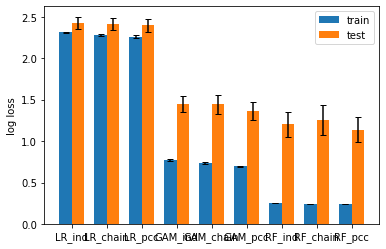

In [12]:
interpolation.plot_summary('log loss')

In [13]:
interpolation.summary()

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_hamming loss,std_train_hamming loss,mean_test_hamming loss,std_test_hamming loss,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
LR_ind,0.414956,0.011141,0.391754,0.13793,0.208354,0.004333,0.21932,0.051786,2.31492,0.03887,2.430065,0.393103
LR_chain,0.43721,0.034576,0.388246,0.140634,0.202747,0.009008,0.219364,0.052299,2.282581,0.070289,2.417791,0.410445
LR_pcc,0.439016,0.036801,0.393421,0.145092,0.202572,0.00939,0.216798,0.054655,2.260522,0.0999,2.397234,0.413784
GAM_ind,0.859332,0.013622,0.687105,0.12839,0.040104,0.0042,0.096864,0.040289,0.772765,0.051352,1.445886,0.530584
GAM_chain,0.865156,0.010399,0.714298,0.129146,0.039871,0.002686,0.090132,0.041415,0.735672,0.03508,1.443986,0.640412
GAM_pcc,0.865971,0.009277,0.710965,0.121,0.040643,0.003017,0.093487,0.03744,0.695308,0.035769,1.360931,0.601632
RF_ind,1.0,0.0,0.788684,0.079754,0.0,0.0,0.065548,0.030316,0.253735,0.003013,1.20225,0.829121
RF_chain,1.0,0.0,0.788772,0.081837,0.0,0.0,0.065066,0.031873,0.240242,0.002532,1.255799,0.966351
RF_pcc,0.999884,0.000443,0.785526,0.071742,0.000044,0.000176,0.068399,0.028642,0.240242,0.002532,1.138964,0.812031


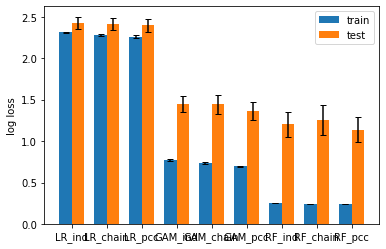

In [15]:
interpolation.plot_summary('log loss')

In [16]:
interpolation.summary()

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_hamming loss,std_train_hamming loss,mean_test_hamming loss,std_test_hamming loss,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
LR_ind,0.414956,0.011141,0.391754,0.13793,0.208354,0.004333,0.21932,0.051786,2.31492,0.03887,2.430065,0.393103
LR_chain,0.43721,0.034576,0.388246,0.140634,0.202747,0.009008,0.219364,0.052299,2.282581,0.070289,2.417791,0.410445
LR_pcc,0.439016,0.036801,0.393421,0.145092,0.202572,0.00939,0.216798,0.054655,2.260522,0.0999,2.397234,0.413784
GAM_ind,0.859332,0.013622,0.687105,0.12839,0.040104,0.0042,0.096864,0.040289,0.772765,0.051352,1.445886,0.530584
GAM_chain,0.865156,0.010399,0.714298,0.129146,0.039871,0.002686,0.090132,0.041415,0.735672,0.03508,1.443986,0.640412
GAM_pcc,0.865971,0.009277,0.710965,0.121,0.040643,0.003017,0.093487,0.03744,0.695308,0.035769,1.360931,0.601632
RF_ind,1.0,0.0,0.788684,0.079754,0.0,0.0,0.065548,0.030316,0.253735,0.003013,1.20225,0.829121
RF_chain,1.0,0.0,0.788772,0.081837,0.0,0.0,0.065066,0.031873,0.240242,0.002532,1.255799,0.966351
RF_pcc,0.999884,0.000443,0.785526,0.071742,0.000044,0.000176,0.068399,0.028642,0.240242,0.002532,1.138964,0.812031


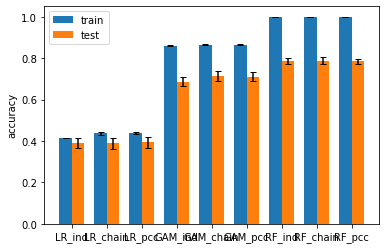

In [17]:
interpolation.plot_summary('accuracy')

## Extrapolation performance



In [20]:
from unicodedata import name
from modules.experiments import ExtrapolationExperiment, sample_size, GroupDescription, GroupKFoldSpecial, error
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score

extrapolation = ExtrapolationExperiment(estimators, 
                            names,
                            GroupKFoldSpecial(len(set(data.comp_ids)), size=22),
                            data.x1, data.y.replace(-1.0, 0.0), groups=data.comp_ids.array,
                            evaluators=[hamming_loss, error, NegLogLikelihoodEvaluator(base=2),
                            GroupDescription(data.comp_descr, 'composition')],
                            verbose=True).run()

Running experiment with 29 repetitions
*****************************


In [21]:
extrapolation.summary()

,mean_train_hamming loss,std_train_hamming loss,mean_test_hamming loss,std_test_hamming loss,mean_train_error,std_train_error,mean_test_error,std_test_error,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
LR_ind,0.21073,0.005103,0.192697,0.148442,0.590885,0.01449,0.622718,0.435049,2.323243,0.029748,2.68269,1.669078
LR_chain,0.205831,0.008311,0.203941,0.168342,0.570269,0.03151,0.615973,0.449275,2.295894,0.047773,2.697661,1.809718
LR_pcc,0.204002,0.010628,0.199708,0.166414,0.56655,0.037625,0.608891,0.447396,2.27317,0.083029,2.674861,1.793803
GAM_ind,0.039104,0.003568,0.143959,0.169203,0.134987,0.011426,0.384604,0.4162,0.73938,0.048631,2.876446,3.630023
GAM_chain,0.038868,0.003073,0.142245,0.170775,0.130333,0.010391,0.373567,0.41929,0.712891,0.050629,3.294095,5.080306
GAM_pcc,0.040066,0.00347,0.146702,0.173823,0.133519,0.010856,0.376702,0.420958,0.671179,0.051213,2.544994,3.358591
RF_ind,0.0,0.0,0.120564,0.184069,0.0,0.0,0.280342,0.401428,0.254496,0.003014,2.007258,2.644255
RF_chain,0.0,0.0,0.125535,0.187844,0.0,0.0,0.285268,0.400556,0.238704,0.003475,1.78431,2.05016
RF_pcc,0.000294,0.000472,0.118843,0.184329,0.000588,0.000943,0.26425,0.388123,0.238704,0.003475,1.640178,1.858515


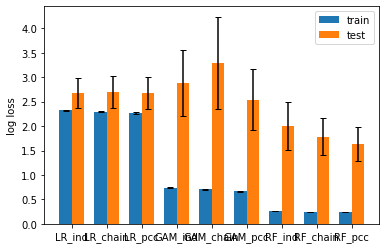

In [22]:
extrapolation.plot_summary('log loss')

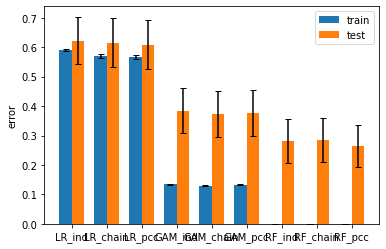

In [24]:
extrapolation.plot_summary('error')

In [29]:
extrapolation.results_[extrapolation.results_.estimator=='RF_ind'].sort_values(['test_error'], ascending=False)

,split,estimator,train_hamming loss,test_hamming loss,train_error,test_error,train_log loss,test_log loss,test_composition
258,28,RF_ind,0.0,0.5,0.0,1.0,0.25217,4.186785,GMA/GlyMA(0.143)+HPMA(0.857)
96,10,RF_ind,0.0,0.285714,0.0,1.0,0.249266,2.826642,GMA/HEMA
159,17,RF_ind,0.0,0.5,0.0,1.0,0.251363,7.959235,GMA/HPMA(0.99)+yclic(0.01)
123,13,RF_ind,0.0,0.541667,0.0,1.0,0.249646,11.899522,MAcEPyr/HPMA
150,16,RF_ind,0.0,0.4,0.0,0.8,0.249405,5.01739,HPMAm/HPMA
6,0,RF_ind,0.0,0.420455,0.0,0.772727,0.251999,4.70283,CysMA/HPMA
33,3,RF_ind,0.0,0.183333,0.0,0.733333,0.254342,1.927066,GMA/GlyMA
87,9,RF_ind,0.0,0.214286,0.0,0.714286,0.251701,2.736039,GMA/HPMA(0.995)+yclic(0.005)
51,5,RF_ind,0.0,0.25,0.0,0.636364,0.256374,2.469345,GluMA/HPMA
42,4,RF_ind,0.0,0.107143,0.0,0.285714,0.25616,2.442751,MAA/HBMA


In [ ]:
extrapolation.results_[extrapolation.results_.estimator=='RF_ind'].sort_values(['test_accuracy', 'test_size'], ascending=False)

,split,estimator,train_accuracy,test_accuracy,train_log loss,test_log loss,train_size,test_size,test_composition
45,7,RF_ind,0.998285,1.0,0.244161,1.033429,583,25,GMA/TFMA
69,11,RF_ind,0.996622,1.0,0.245213,0.54748,592,16,GMA/BzMA
93,15,RF_ind,0.998331,1.0,0.240698,0.715275,599,9,KSPMA/HPMA
99,16,RF_ind,0.998333,1.0,0.243188,0.136622,600,8,AEMA/HPMA
105,17,RF_ind,0.998336,1.0,0.242729,0.310692,601,7,AcETMAC/DAAM
123,20,RF_ind,0.998336,1.0,0.243005,1.22087,601,7,DMA/PhA
129,21,RF_ind,0.996678,1.0,0.238026,0.46179,602,6,MAcEPyr/EGEMA
135,22,RF_ind,0.998339,1.0,0.238902,0.958849,602,6,GMA/HBMA
159,26,RF_ind,0.99835,1.0,0.234696,0.074001,606,2,MPC/HPMA(0.985)+EGDMA(0.015)
165,27,RF_ind,0.99835,1.0,0.234838,0.074001,606,2,MPC/HPMA(0.988)+EGDMA(0.012)


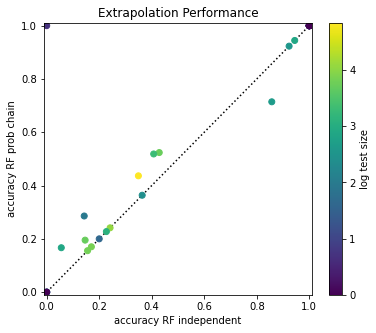

In [ ]:
from matplotlib import pyplot as plt
from numpy import log

fig, ax = plt.subplots(figsize=(6, 5))
plt.plot([-0.05, 1.05], [-0.05, 1.05], linestyle=':', color='black', zorder=-1)
scatter = ax.scatter(
    extrapolation.results_[extrapolation.results_.estimator == 'RF_ind']['test_accuracy'], 
    extrapolation.results_[extrapolation.results_.estimator == 'RF_pcc']['test_accuracy'],
    marker='o', c=log(extrapolation.results_[extrapolation.results_.estimator == 'RF_ind']['test_size'].astype('int')))
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xlabel('accuracy RF independent')
plt.ylabel('accuracy RF prob chain')
plt.title('Extrapolation Performance')
plt.colorbar(scatter, label='log test size')
plt.show()